In [2]:
%matplotlib inline

import seaborn
from matplotlib import style
import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn-ticks')

In [3]:
import psycopg2 as pg
from sqlalchemy import create_engine
import pandas as pd

# 连接数据库
con = create_engine('postgresql://derekhe@localhost/mobike')

# 从数据库中直接读取到DataFrame中
df = pd.read_sql_table("mobike_20180529",  con = con)

con.dispose()

In [4]:
# 单车数量
total = len(df.bike_id.unique())
total

305405

In [5]:
# 载入Cython进行编译，加速数据处理
%load_ext Cython

In [6]:
%%cython
import math
import datetime
from geopy.distance import great_circle
import pandas as pd

i = 0

def calc_distance(r):
    d = great_circle((r['lng'], r['lat']), (r['lng2'], r['lat2'])).meters
    # 100米以下的移动可以认为是GPS的漂移
    return 0 if d < 100 else d
    
def shift_loc(g):
    global i, total
    
    # 增加一条新的记录到最后用于收尾
    tail = g.tail(1).copy()
    tail.crawl_date = datetime.datetime(2018,5,30)
    g = g.append(tail, ignore_index=True)
    
    # 计算偏移量
    g[['lat2','lng2']] = g[['lat','lng']].shift(-1).fillna(method='ffill')
    g['distance'] = g.apply(calc_distance, axis=1)
    
    # 由于可能存在GPS漂移，所以会有多个连续的距离为0的数据。这里将中间的数据进行移除，达到合并数据的目的
    g = g.drop(g[(g.distance == 0) & ((g.distance==0).shift(1))].index[:-1])    
    
    # 计算时间差
    g['start_time'] = g.crawl_date
    g['end_time'] = g.crawl_date.shift(-1).fillna(method='ffill')
    g['time_diff'] = g.end_time - g.start_time
    
    # 打印进度
    i= i + 1
    if i % 1000 ==0 :
        print(i, datetime.datetime.now())
        
    # 移除最后一条多余的记录
    return g[:-1]

In [ ]:
# 小范围的看一下单车的情况，快速展示算法
df_bikes = df[df.bike_id.isin(df.bike_id.values[5000:6000])]

df_detail = df_bikes.groupby('bike_id').apply(shift_loc).set_index(['bike_id', 'crawl_date']).sort_index()

In [7]:
# 全量计算所有的单车信息，在intel i7 3770K@4.5G处理器上，需要耗时接近一个小时
# 去掉注释以运行，请注意电脑的内存消耗
# df_detail = df.groupby('bike_id').apply(shift_loc).set_index(['bike_id', 'crawl_date']).sort_index()

# 读取上一次存储的结果而不用反复计算
df_detail = pd.read_hdf("bike_detail.hdf", key='bike')

计算使用次数

In [11]:
%%cython
def num_of_usage(g):
    return len(g[g['distance'] != 0])

In [12]:
usage_count = df_detail.groupby('bike_id').apply(num_of_usage).sort_values(ascending=False)
usage_count

bike_id
0216189652#    57
0216521860#    55
0216632422#    38
0216799153#    18
8620888950#    18
0216500154#    18
0216820962#    17
0216731615#    17
8621559366#    17
8621531992#    17
0216849253#    17
0216707762#    17
0216578159#    17
8620816725#    17
0216811740#    17
0216559484#    16
0216791340#    16
8620814985#    16
8620415521#    16
0216509735#    16
8621559139#    16
8620610890#    16
8621725407#    16
0216683844#    16
0216702729#    16
0210113956#    16
0216542626#    15
8621526223#    15
0216616658#    15
8621322863#    15
               ..
0216686134#     0
0216686130#     0
0216686123#     0
0216686117#     0
0216686113#     0
8621526298#     0
0216686104#     0
0216686173#     0
0216686179#     0
0216686273#     0
0216686208#     0
0216686250#     0
8621526288#     0
0216686236#     0
0216686235#     0
0216686227#     0
0216686224#     0
0216686223#     0
0216686218#     0
0216686206#     0
0216686185#     0
8621526289#     0
0216686200#     0
0216686199#     0
02

In [9]:
# 将计算结果存下来以便后续使用
df_detail.to_hdf("bike_detail.hdf", key='bike')

In [22]:
# 单车的详细情况
df_detail.loc[usage_count[usage_count==2].index[0]]

,lat,lng,lat2,lng2,distance,start_time,end_time,time_diff
crawl_date,,,,,,,,
2018-05-29 07:40:54,121.466822,31.305110,121.467663,31.310345,587.563977,2018-05-29 07:40:54,2018-05-29 08:28:00,00:47:06
2018-05-29 08:28:00,121.467663,31.310345,121.467663,31.310345,0.000000,2018-05-29 08:28:00,2018-05-29 10:35:51,02:07:51
2018-05-29 10:35:51,121.467663,31.310345,121.490196,31.333375,3337.532865,2018-05-29 10:35:51,2018-05-29 15:07:42,04:31:51
2018-05-29 15:07:42,121.490196,31.333375,121.490196,31.333375,0.000000,2018-05-29 15:07:42,2018-05-30 00:00:00,08:52:18


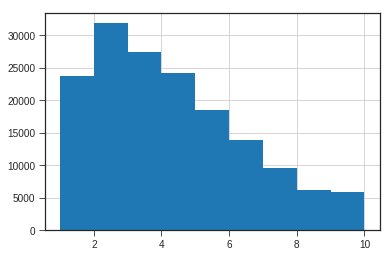

In [11]:
# 使用次数分布图
usage_count[usage_count!=0].hist(bins=range(1,11))

In [12]:
# 未移动的单车的比例
len(usage_count[usage_count == 0]) / len(usage_count) * 100

46.48548648515905

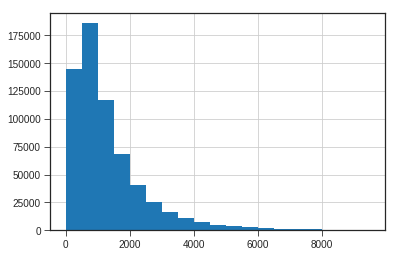

In [13]:
# 出行距离统计
df_detail[df_detail.distance!=0]['distance'].hist(bins=range(0, 10000, 500))

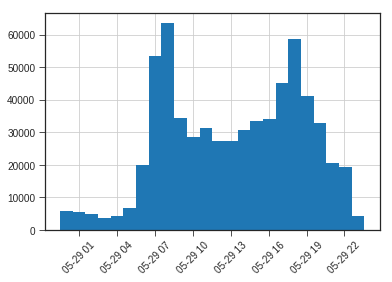

In [14]:
# 出行时段统计
df_detail[df_detail.distance!=0]['start_time'].hist(bins=24, xrot=45)

In [19]:
df_detail.loc[usage_count[usage_count==18].index[0]].to_csv('bike_movement.csv')